In [ ]:
!pip install transformers
!pip install gdown

     |████████████████████████████████| 1.5MB 8.8MB/s 
     |████████████████████████████████| 2.9MB 31.6MB/s 
     |████████████████████████████████| 890kB 66.2MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=3480f76a21db35a4d8b2b3c02fbf1b7f491e04288ed02e2b8c1dc91568308dcb
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


In [ ]:
!gdown https://drive.google.com/uc?id=1NNpbV5N9MDj4vn-k5ANT1nqY9-z_vGRa
!gdown https://drive.google.com/uc?id=18iBU4VFLg8zCrh5iZ66mbLJ51iJaWs4Z

Downloading...
From: https://drive.google.com/uc?id=1NNpbV5N9MDj4vn-k5ANT1nqY9-z_vGRa
To: /content/test.csv
100% 331k/331k [00:00<00:00, 102MB/s]
Downloading...
From: https://drive.google.com/uc?id=18iBU4VFLg8zCrh5iZ66mbLJ51iJaWs4Z
To: /content/train.csv
100% 974k/974k [00:00<00:00, 62.1MB/s]


#  kitapyurdu.com - REVIEWS AND RATINGS DATASET

Original kitapyurdu.com dataset contains around 125K reviews and ratings. However, training the model with this amount takes a lot of time. Therefore, we previously prepare the data as highly balanced and smaller size. The reason for that **handling imbalanced data is advanced topic, if you are interestedn in this, [you can follow this paper.](https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=5128907)** The script includes data preparation steps will be shared with participants after the workshop.

In [ ]:
import pandas as pd
df_train = pd.read_csv(r"train.csv",index_col=[0])
# Report the number of sentences.
print('Number of training sentences: {:,}\n'.format(df_train.shape[0]))
print(df_train["label"].value_counts())
print("\n")
df_test = pd.read_csv(r"test.csv",index_col=[0])
# Report the number of sentences.
print('Number of test sentences: {:,}\n'.format(df_test.shape[0]))
print(df_test["label"].value_counts())

Number of training sentences: 7,050

2    2350
1    2350
0    2350
Name: label, dtype: int64


Number of test sentences: 2,400

1    800
2    800
0    800
Name: label, dtype: int64


**Classes:**



0.   Negative
1.   Neutral
2.   Positive


In [ ]:
df_train.sample(5)

,review,label
6821,Sünnetler eşliğinde çocuk eğitimi,2
3586,Yogun bi sekilde kasvetlendirdigi icin cok da ...,1
6955,Emeklerine sağlık Yılmaz Özdil' in. Bilgi depo...,2
4073,genel olarak sabahattin ali nin diline hayranı...,1
6210,Bir kaç kitabını okudum ve hepsi birbirinden g...,2


In [ ]:
df_test.sample(5)

,review,label
2339,Bazen aradıklarımız gözümüzün önünde olmasına ...,2
41,Gerçekçi bulmadığım için çok da beğenemedim,0
50,"Tavsiye üzerine aldığım, okunması için boşa ge...",0
2070,kesinlikle 5 yıldızı hak ediyor. alın.okuyun.,2
554,bu kitap aşırı betimlemeleri sevmediğimi anlam...,0


## TEXT PREPROCESSING

In [ ]:
df_test["label"].unique()

array([0, 1, 2])

In [ ]:
df_train.review[0]

'Kitabı bugün 3. defa kaldığım yerden devam etmek için elime aldım. Ancak yine daha iyi anlamak için baştan başladım(3. defa). Hatta kararsızım okuyup okumamakta, çünkü bir türlü ilerleyemiyorum kitapta bayağı sıkıyor beni. Hadi bakalım inşallah bu sefer bitireceğim kitabı. Son yapılan yoruma istinaden umarım 140. sayfadan sonra ben de aynı düşüncelere sahip olurum.'

#### Stemming, lemmatization and the removal process of "stopwords", "punctuations" or "numerical values" are not required, since subword tokenizers and Transformer networks can deal with these.

In [ ]:
import re
def preprocess(text):
  text=text.lower()
  
  text=text.replace("\n"," ")
  #removing URL
  text = re.sub(r'https?:\/\/.*[\r\n]*', '', text)
  text = re.sub(r'http?:\/\/.*[\r\n]*', '', text)

  #Replace &amp, &lt, &gt with &,<,> respectively
  text=text.replace(r'&amp;?',r'and')
  text=text.replace(r'&lt;',r'<')
  text=text.replace(r'&gt;',r'>')

  #remove hashtags
  text=re.sub(r"#[A-Za-z0-9]+","",text)   
  #remove \
  text=re.sub(r"\\ "," ",text)
  #remove excess whitespace
  text= ' '.join(text.split())
  return text

df_train["review"]=df_train["review"].apply(preprocess)
df_test["review"]=df_test["review"].apply(preprocess)

In [ ]:
df_train.review[0]

'kitabı bugün 3. defa kaldığım yerden devam etmek için elime aldım. ancak yine daha iyi anlamak için baştan başladım(3. defa). hatta kararsızım okuyup okumamakta, çünkü bir türlü ilerleyemiyorum kitapta bayağı sıkıyor beni. hadi bakalım inşallah bu sefer bitireceğim kitabı. son yapılan yoruma istinaden umarım 140. sayfadan sonra ben de aynı düşüncelere sahip olurum.'

##### **BEFORE PREPROCESSING:**

> Kitabı bugün 3. defa kaldığım yerden devam etmek için elime aldım. Ancak yine daha iyi anlamak için baştan başladım(3. defa). Hatta kararsızım okuyup okumamakta, çünkü bir türlü ilerleyemiyorum kitapta bayağı sıkıyor beni. Hadi bakalım inşallah bu sefer bitireceğim kitabı. Son yapılan yoruma istinaden umarım 140. sayfadan sonra ben de aynı düşüncelere sahip olurum.

# WordClouds

**WORD CLOUD FOR NEGATIVE REVIEWS** 

In [ ]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

stop_words=stopwords.words("turkish")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


(-0.5, 1199.5, 799.5, -0.5)

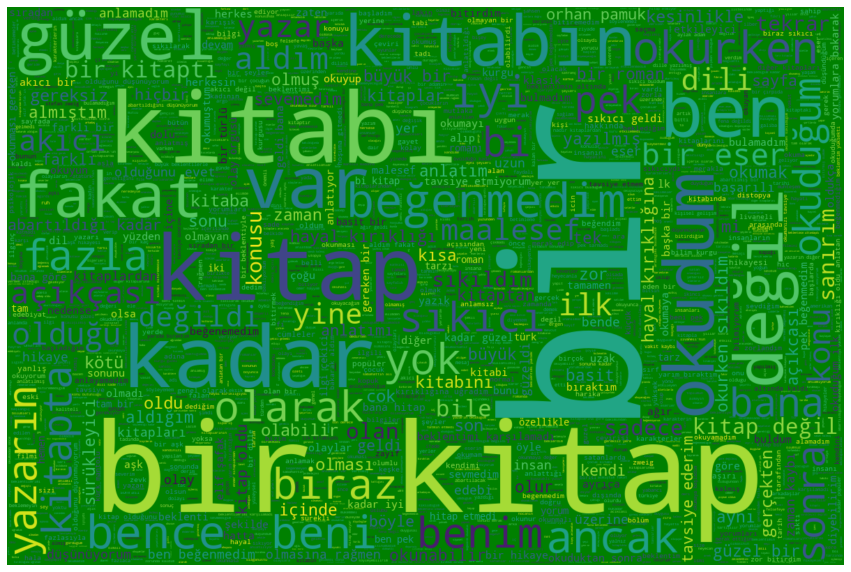

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from wordcloud import WordCloud

negative = df_train.review[df_train.label[df_train.label==0].index]
plt.figure(figsize = (15,20)) ;
wordcloud = WordCloud(min_font_size = 3,  max_words = 2500 , width = 1200 , height = 800,background_color="green",stopwords=stop_words).generate(" ".join(negative))
plt.imshow(wordcloud,interpolation = 'bilinear')
plt.axis("off")

**WORD CLOUD FOR NEURAL REVIEWS** 

(-0.5, 1199.5, 799.5, -0.5)

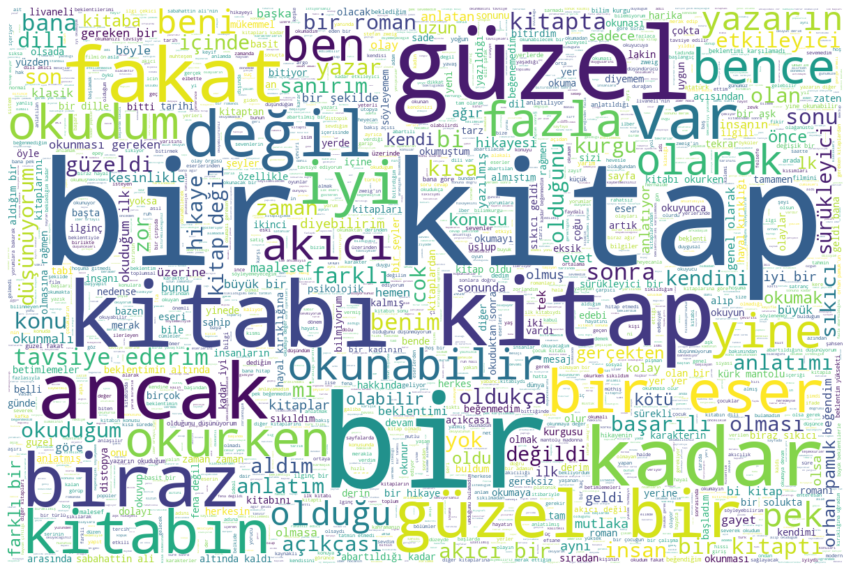

In [ ]:
neutral = df_train.review[df_train.label[df_train.label==1].index]
plt.figure(figsize = (15,20)) ;
wordcloud = WordCloud(min_font_size = 3,  max_words = 2500 , width = 1200 , height = 800,background_color="white",stopwords=stop_words).generate(" ".join(neutral))
plt.imshow(wordcloud,interpolation = 'bilinear')
plt.axis("off")

**WORD CLOUD FOR POSITIVE REVIEWS** 

(-0.5, 1199.5, 799.5, -0.5)

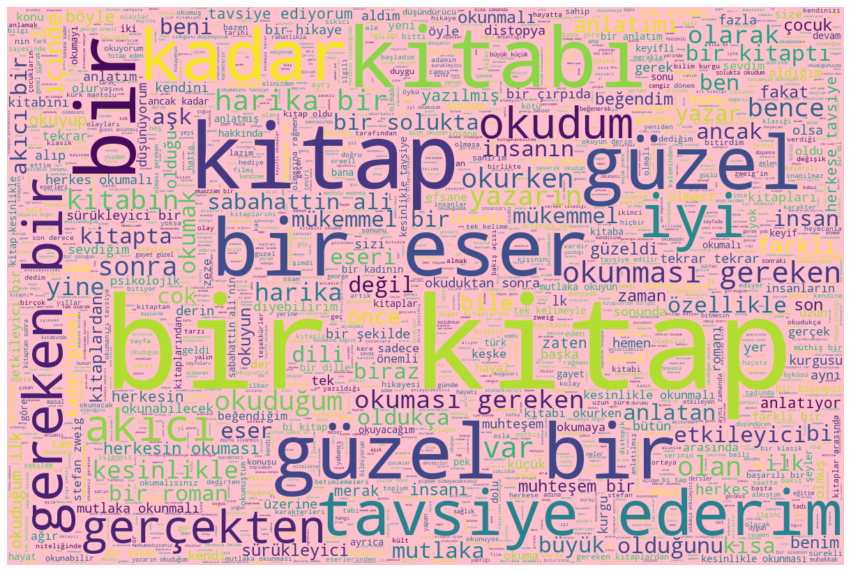

In [ ]:
positive = df_train.review[df_train.label[df_train.label==2].index]
plt.figure(figsize = (15,20)) ;
wordcloud = WordCloud(min_font_size = 3,  max_words = 2500 , width = 1200 , height = 800,background_color="pink",stopwords=stop_words).generate(" ".join(positive))
plt.imshow(wordcloud,interpolation = 'bilinear')
plt.axis("off")

# MODELLING

In [ ]:
texts = df_train.review.values
labels = df_train.label.values

In [ ]:
#BERT MODEL
from transformers import AutoModelForSequenceClassification, AutoTokenizer, AutoConfig, AdamW
tokenizer = AutoTokenizer.from_pretrained("dbmdz/bert-base-turkish-cased")
config=AutoConfig.from_pretrained("dbmdz/bert-base-turkish-cased",num_labels=3)
model = AutoModelForSequenceClassification.from_pretrained("dbmdz/bert-base-turkish-cased",config=config)

model.cuda()

Some weights of the model checkpoint at dbmdz/bert-base-turkish-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were 

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(32000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [ ]:
#to show length of embedding will be helpful to determine maximum length of comments and padding threshold
import matplotlib.pyplot as plt
def plot_sentence_embeddings_length(text_list, tokenizer):
    tokenized_texts = list(map(lambda t: tokenizer.tokenize(t), text_list))
    tokenized_texts_len = list(map(lambda t: len(t), tokenized_texts))
    fig, ax = plt.subplots(figsize=(8, 5));
    ax.hist(tokenized_texts_len, bins=40);
    ax.set_xlabel("Length of Comment Embeddings");
    ax.set_ylabel("Number of Comments");
    return

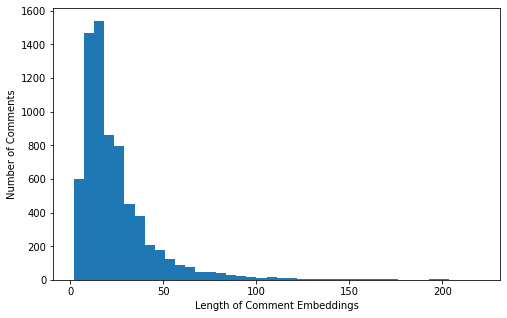

In [ ]:
plot_sentence_embeddings_length(texts, tokenizer)

In [ ]:
type(texts)

numpy.ndarray

In [ ]:
#256 length
indices=tokenizer.batch_encode_plus(list(texts),max_length=256,add_special_tokens=True, return_attention_mask=True,pad_to_max_length=True,truncation=True)

input_ids=indices["input_ids"]
attention_masks=indices["attention_mask"]
print(input_ids[0])
print(attention_masks[0])

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2179: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


[2, 6656, 3120, 23, 18, 4635, 30473, 7197, 2570, 3053, 2058, 20501, 6713, 18, 3092, 3246, 2171, 2395, 9977, 2058, 9719, 8842, 12, 23, 18, 4635, 13, 18, 4495, 24839, 2027, 18371, 6626, 2376, 16, 3845, 1996, 3973, 22433, 9395, 14420, 18331, 7427, 2057, 3216, 18, 12142, 8088, 10698, 2048, 4773, 4851, 4224, 6656, 18, 2094, 2714, 3568, 1006, 21233, 12538, 14485, 18, 27871, 2288, 2245, 2012, 2681, 12778, 1025, 2586, 14560, 18, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 1, 1, 1, 1, 1, 1, 1, 1

In [ ]:
from sklearn.model_selection import train_test_split


train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                            random_state=42, test_size=0.2)

train_masks, validation_masks, _, _ = train_test_split(attention_masks, labels,
                                             random_state=42, test_size=0.2)

In [ ]:
# Convert all of our data into torch tensors, the required datatype for our model
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels, dtype=torch.long)
validation_labels = torch.tensor(validation_labels, dtype=torch.long)
train_masks = torch.tensor(train_masks, dtype=torch.long)
validation_masks = torch.tensor(validation_masks, dtype=torch.long)

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

batch_size = 32

# Create the DataLoader for our training set.
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set.
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [ ]:
optimizer = AdamW(model.parameters(),lr = 5e-5, eps = 1e-8) #authors recommend 5e-5
from transformers import get_linear_schedule_with_warmup
# Number of training epochs (authors recommend between 2 and 4)
epochs = 4
# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0, num_training_steps = total_steps)

In [ ]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
import random

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128


# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

loss_values = []
start_time=time.time()
# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_loss = 0

    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 100 batches.
        if step % 50 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # This will return the loss (rather than the model output) because we
        # have provided the `labels`.
        outputs = model(b_input_ids, 
                    attention_mask=b_input_mask, 
                    labels=b_labels)
        
        # The call to `model` always returns a tuple, so we need to pull the 
        # loss value out of the tuple.
        loss = outputs[0]

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)            
    
    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(format_time(time.time() - t0)))

    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    preds=[]
    true=[]

    # Tracking variables 
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        
        # Telling the model not to compute or store gradients, saving memory and
        # speeding up validation
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have
            # not provided labels.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.

            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        
        # Get the "logits" output by the model. The "logits" are the output
        # values prior to applying an activation function like the softmax.
        logits = outputs[0]

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        preds.append(logits)
        true.append(label_ids)
        # Calculate the accuracy for this batch of test sentences.
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        
        # Accumulate the total accuracy.
        eval_accuracy += tmp_eval_accuracy

        # Track the number of batches
        nb_eval_steps += 1

    # Report the final accuracy for this validation run.
    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))
      
print("")
print("Whole Training took: {:}".format(format_time(time.time()-start_time)))
print("Training complete!")


======== Epoch 1 / 4 ========
Training...
  Batch    50  of    177.    Elapsed: 0:00:39.
  Batch   100  of    177.    Elapsed: 0:01:18.
  Batch   150  of    177.    Elapsed: 0:01:57.

  Average training loss: 0.83
  Training epoch took: 0:02:17

Running Validation...
  Accuracy: 0.65
  Validation took: 0:00:11

======== Epoch 2 / 4 ========
Training...
  Batch    50  of    177.    Elapsed: 0:00:39.
  Batch   100  of    177.    Elapsed: 0:01:18.
  Batch   150  of    177.    Elapsed: 0:01:57.

  Average training loss: 0.63
  Training epoch took: 0:02:17

Running Validation...
  Accuracy: 0.63
  Validation took: 0:00:11

======== Epoch 3 / 4 ========
Training...
  Batch    50  of    177.    Elapsed: 0:00:39.
  Batch   100  of    177.    Elapsed: 0:01:18.
  Batch   150  of    177.    Elapsed: 0:01:57.

  Average training loss: 0.45
  Training epoch took: 0:02:17

Running Validation...
  Accuracy: 0.65
  Validation took: 0:00:11

======== Epoch 4 / 4 ========
Training...
  Batch    50  of 

#TESTING THE MODEL

In [ ]:
texts1 = df_test.review.values
labels1 = df_test.label.values

indices=tokenizer.batch_encode_plus(list(texts1),max_length=256,add_special_tokens=True, return_attention_mask=True,pad_to_max_length=True,truncation=True)
input_ids1=indices["input_ids"]
attention_masks1=indices["attention_mask"]

# Convert to tensors.
prediction_inputs1= torch.tensor(input_ids1)
prediction_masks1 = torch.tensor(attention_masks1)
prediction_labels1 = torch.tensor(labels1)

# Set the batch size.  
batch_size = 32 

# Create the DataLoader.
prediction_data1 = TensorDataset(prediction_inputs1, prediction_masks1, prediction_labels1)
prediction_sampler1 = SequentialSampler(prediction_data1)
prediction_dataloader1 = DataLoader(prediction_data1, sampler=prediction_sampler1, batch_size=batch_size)

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2179: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(prediction_inputs1)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader1:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids1, b_input_mask1, b_labels1 = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs1 = model(b_input_ids1, token_type_ids=None, 
                      attention_mask=b_input_mask1)

  logits1 = outputs1[0]

  # Move logits and labels to CPU
  logits1 = logits1.detach().cpu().numpy()
  label_ids1 = b_labels1.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits1)
  true_labels.append(label_ids1)

print('TEST PROCESS COMPLETED.')

Predicting labels for 2,400 test sentences...
TEST PROCESS COMPLETED.


In [ ]:
# Combine the predictions for each batch into a single list of 0s and 1s.
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
# Combine the correct labels for each batch into a single list.
flat_true_labels = [item for sublist in true_labels for item in sublist]

In [ ]:
from sklearn.metrics import accuracy_score,confusion_matrix
print("Accuracy of BERT is:",accuracy_score(flat_true_labels, flat_predictions))
from sklearn.metrics import classification_report
print(classification_report(flat_true_labels, flat_predictions))

Accuracy of BERT is: 0.6575
              precision    recall  f1-score   support

           0       0.70      0.62      0.66       800
           1       0.54      0.57      0.55       800
           2       0.74      0.78      0.76       800

    accuracy                           0.66      2400
   macro avg       0.66      0.66      0.66      2400
weighted avg       0.66      0.66      0.66      2400



<Figure size 432x288 with 0 Axes>

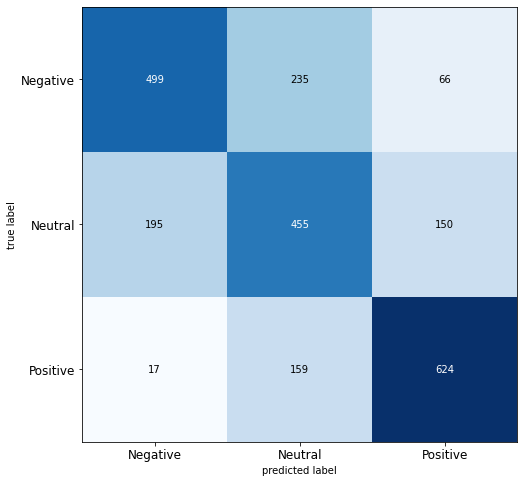

In [ ]:
cm  = confusion_matrix(flat_true_labels, flat_predictions)
labels = ['Negative', 'Neutral', 'Positive']
from mlxtend.plotting import plot_confusion_matrix
plt.figure()
plot_confusion_matrix(cm, figsize=(8,8), hide_ticks=True, cmap=plt.cm.Blues)
plt.xticks(range(3), labels, fontsize=12)
plt.yticks(range(3), labels, fontsize=12)
plt.show()